In [35]:
"""
# Swirl Correction Project - Final Submission
## A Two-Stage Approach for Swirl Defect Detection and Correction

This notebook implements a novel approach to correct swirl artifacts in images using:
1. A mask prediction network to locate the swirl defect
2. A correction network that uses the predicted mask to guide the restoration

### Key Achievements:
- Total parameters: < 4M (Mask: ~500K, Correction: ~3.4M)
- Mean correction ratio: ~0.15 (85% improvement over initial defect)
- Robust to various swirl intensities and positions
"""

# === IMPORTS ===
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from skimage.transform import swirl
from skimage.draw import disk
import matplotlib.pyplot as plt
import os
from datetime import datetime

print(f"TensorFlow version: {tf.__version__}")
print(f"Running on: {'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'}")

# === CONFIGURATION ===
IMG_SIZE = 128
DEFECT_RADIUS = 32
STRENGTH = 4
BATCH_SIZE = 32
EPOCHS_MASK = 20
EPOCHS_CORRECTION = 100

TensorFlow version: 2.18.0
Running on: GPU


In [36]:
# === DATA PREPROCESSING ===
def preprocess_image(sample):
    """Resize and normalize image"""
    image = tf.image.resize(sample['image'], (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image

def generate_swirl_defect(image_np):
    """Generate swirl defect with random parameters"""
    h, w = image_np.shape[:2]
    radius = int(DEFECT_RADIUS * np.random.uniform(0.5, 1.))
    strength = STRENGTH * np.random.uniform(0.5, 1.)
    center = np.random.randint(radius, h - radius, size=2)
    swirled = swirl(image_np, center=center[::-1], strength=strength, radius=radius)
    mask = np.zeros((h, w, 1), dtype=np.uint8)
    rr, cc = disk(center, radius, shape=(h, w))
    mask[rr, cc] = 1
    return swirled.astype(np.float32), mask

In [37]:
# === DATA GENERATOR ===
class SwirlDefectGenerator(tf.keras.utils.Sequence):
    """Generator for creating swirl defects on-the-fly"""
    def __init__(self, images, batch_size=32, shuffle=True, mode="all"):
        self.images = images
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(images))
        if self.shuffle:
            np.random.shuffle(self.indices)
        self.mode = mode

    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_clean = self.images[batch_indices]
        batch_defected = []
        batch_masks = []

        for img in batch_clean:
            swirled, mask = generate_swirl_defect(img)
            batch_defected.append(swirled)
            batch_masks.append(mask)

        batch_defected = np.array(batch_defected)
        batch_masks = np.array(batch_masks)

        if self.mode == "mask":
            return batch_defected, batch_masks
        elif self.mode == "correction":
            return batch_defected, batch_clean
        else:  # mode == "all"
            return batch_defected, batch_masks, batch_clean

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [38]:
# === LOAD DATASET ===
print("\nLoading TensorFlow Flowers dataset...")

def load_flower_dataset_splits(num_train=3000, num_val=300, num_test=370):
    """Load and split the flowers dataset"""
    ds = tfds.load('tf_flowers', split='train', shuffle_files=True)
    ds = ds.map(preprocess_image)
    all_images = tf.stack(list(ds))
    print(f"Total images loaded: {len(all_images)}")
    return (
        all_images[:num_train].numpy(),
        all_images[num_train:num_train + num_val].numpy(),
        all_images[num_train + num_val:num_train + num_val + num_test].numpy()
    )

train_imgs, val_imgs, test_imgs = load_flower_dataset_splits()
print(f"Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")



Loading TensorFlow Flowers dataset...
Total images loaded: 3670
Train: 3000, Val: 300, Test: 370


New generator to adapt image batch for the input of the net



In [39]:
# =========================================================
# 1)  WRAPPER GENERATOR  —  usa la maschera PREDOTTA
# =========================================================
class MaskedSwirlGenerator(tf.keras.utils.Sequence):
    def __init__(self, base_gen, mask_model):
        self.base_gen, self.mask_model = base_gen, mask_model
        self.mask_model.trainable = False

    def __len__(self):
        return len(self.base_gen)

    def __getitem__(self, idx):
        BETA  = 0.30   # weight out of the mask
        ALPHA = 1.0    # weight in the mask


        x_def, y_clean = self.base_gen[idx]

        m_pred = self.mask_model.predict(x_def, verbose=0)      # (B,128,128,1)
        m_rgb  = np.repeat(m_pred, 3, axis=-1).astype(np.float32)   # (B,128,128,3)
        m_single = (BETA + (ALPHA - BETA) * m_pred.squeeze(-1)).astype(np.float32)  # shape (B,128,128)

        # ---- inputs dict, targets, sample_weight ----

        return {"defected_img": x_def, "pred_mask": m_rgb}, y_clean, m_single

    def on_epoch_end(self):
        self.base_gen.on_epoch_end()


I chose a U-Net architecture because it is well-suited for image-to-image tasks where
spatial information needs to be preserved, such as defect correction. The skip connections
between encoder and decoder layers help retain fine-grained details and improve the model’s
ability to reconstruct high-quality images. U-Net is also computationally efficient while
delivering strong performance on segmentation-like problems such as mask prediction and
localized image correction.

In [40]:
# === MODEL ARCHITECTURES ===

def conv_block(x, filters, kernel_size=3, use_bn=True):
    """Convolutional block with optional batch normalization"""
    x = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')(x)
    if use_bn:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

# =========================================================
# 1)  MODELLO  —  U‑Net for mask predict
# =========================================================

def build_mask_predictor(input_shape=(128, 128, 3), base_filters=20):
    """
    Mask predictor compatto — ~880k parametri con base_filters=20
    Totale con rete di correzione ≈ 3.93M
    """
    inputs = tf.keras.layers.Input(shape=input_shape)

    f1, f2, f3, f4 = base_filters, base_filters*2, base_filters*4, base_filters*8

    e1 = conv_block(inputs, f1)
    e1 = conv_block(e1, f1)
    p1 = tf.keras.layers.MaxPooling2D()(e1)

    e2 = conv_block(p1, f2)
    e2 = conv_block(e2, f2)
    p2 = tf.keras.layers.MaxPooling2D()(e2)

    e3 = conv_block(p2, f3)
    e3 = conv_block(e3, f3)
    p3 = tf.keras.layers.MaxPooling2D()(e3)

    b = conv_block(p3, f4)
    b = conv_block(b, f4)

    u3 = tf.keras.layers.UpSampling2D()(b)
    u3 = tf.keras.layers.Concatenate()([u3, e3])
    d3 = conv_block(u3, f3)
    d3 = conv_block(d3, f3)

    u2 = tf.keras.layers.UpSampling2D()(d3)
    u2 = tf.keras.layers.Concatenate()([u2, e2])
    d2 = conv_block(u2, f2)
    d2 = conv_block(d2, f2)

    u1 = tf.keras.layers.UpSampling2D()(d2)
    u1 = tf.keras.layers.Concatenate()([u1, e1])
    d1 = conv_block(u1, f1)
    d1 = conv_block(d1, f1)

    outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid', padding='same')(d1)

    model = tf.keras.Model(inputs, outputs, name='mask_predictor_compact')
    print(f"✅ Mask Predictor Params: {model.count_params():,}")
    return model


# =========================================================
# 2)  MODELLO  —  U‑Net Swirl correction
# =========================================================
def build_mask_guided_unet_medium(img_shape=(128,128,3)):
    img_in  = tf.keras.Input(img_shape,  name="defected_img")
    mask_in = tf.keras.Input(img_shape,  name="pred_mask")
    x = tf.keras.layers.Concatenate()([img_in, mask_in])          # 6 channels

    def conv_bn_relu(t, f):
        t = tf.keras.layers.Conv2D(f, 3, padding='same')(t)
        t = tf.keras.layers.BatchNormalization()(t)
        return tf.keras.layers.ReLU()(t)

    # ---------- Encoder ----------
    c1 = conv_bn_relu(x, 40); c1 = conv_bn_relu(c1, 40); p1 = tf.keras.layers.MaxPooling2D()(c1)
    c2 = conv_bn_relu(p1, 80); c2 = conv_bn_relu(c2, 80); p2 = tf.keras.layers.MaxPooling2D()(c2)
    c3 = conv_bn_relu(p2,160); c3 = conv_bn_relu(c3,160); p3 = tf.keras.layers.MaxPooling2D()(c3)

    # ---------- Bottleneck ----------
    b  = conv_bn_relu(p3,320); b  = conv_bn_relu(b ,320)

    # ---------- Decoder ----------
    u3 = tf.keras.layers.UpSampling2D()(b);  u3 = tf.keras.layers.Concatenate()([u3,c3])
    d3 = conv_bn_relu(u3,160); d3 = conv_bn_relu(d3,160)

    u2 = tf.keras.layers.UpSampling2D()(d3); u2 = tf.keras.layers.Concatenate()([u2,c2])
    d2 = conv_bn_relu(u2, 80); d2 = conv_bn_relu(d2, 80)

    u1 = tf.keras.layers.UpSampling2D()(d2); u1 = tf.keras.layers.Concatenate()([u1,c1])
    d1 = conv_bn_relu(u1, 40); d1 = conv_bn_relu(d1, 40)

    out = tf.keras.layers.Conv2D(3, 1, activation='sigmoid')(d1)

    model = tf.keras.Model([img_in, mask_in], out, name="mask_guided_unet_medium")
    return model

In [41]:
import os, subprocess, sys, importlib.util

def _ensure_gdown():
    """Installa gdown se non è ancora disponibile."""
    if importlib.util.find_spec("gdown") is None:
        print("⏳  Installing gdown …")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "gdown"])
    import gdown  # noqa
    return gdown

def load_weights_from_drive(model: tf.keras.Model,
                            file_id: str,
                            local_path: str = "model_weights.h5",
                            overwrite: bool = False):
    """
    Downloads a file from Google Drive (if needed) and loads it into the given model.

    Parameters
    ----------
    model       : tf.keras.Model
        The model instance to load the weights into (already built/compiled).

    file_id     : str
        The Google Drive file ID (the part found in the URL after `/d/` and before `/view`).

    local_path  : str
        Path or filename where the downloaded weights should be saved locally.

    overwrite   : bool
        If True, forces re-download even if the file already exists locally.
    """
    gdown = _ensure_gdown()

    if not os.path.exists(local_path) or overwrite:
        url = f"https://drive.google.com/uc?id={file_id}"
        print(f"⬇️  Downloading weights from Google Drive → {local_path}")
        gdown.download(url, local_path, quiet=False)
    else:
        print(f"✔️  Found existing weights at {local_path} – skipping download")

    print("🔄  Loading weights …")
    model.load_weights(local_path)
    print("✅  Weights loaded!")

    return model

The task is accomplished by predicting a mask from the defected image through a first net.
Then the predicted mask is used in the second net to guide the correction process.
Specifically, the mask highlights the defective region, allowing the second network to focus
its effort on learning how to restore only the damaged areas, while preserving the rest of the image.
This two-stage approach helps decouple localization (masking) from restoration (correction),
improving both interpretability and generalization.


In [42]:
# === BUILD MODELS ===
print("\nBuilding models...")
mask_model = build_mask_predictor()
correction_model = build_mask_guided_unet_medium()

print(f"Mask Predictor Parameters: {mask_model.count_params():,}")
print(f"Correction Network Parameters: {correction_model.count_params():,}")
print(f"Total Parameters: {mask_model.count_params() + correction_model.count_params():,}")

# === TRAINING ===
print("\n" + "="*50)
print("STAGE 1: LOADING MASK PREDICTOR WEIGHTS")
print("="*50)

# Prepare data generators for mask training
train_gen_mask = SwirlDefectGenerator(train_imgs, batch_size=BATCH_SIZE, mode="mask")
val_gen_mask = SwirlDefectGenerator(val_imgs, batch_size=BATCH_SIZE, mode="mask")

# Compile mask model
mask_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)]
)

# Callbacks for mask training
mask_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=7, restore_best_weights=True, verbose=1
    )
]

# Load old weights to continue training mask predictor
Mask_w_ID = '1OB9mfZdiCfncXCobV340povTh8NEsTZH'
load_weights_from_drive(mask_model, file_id=Mask_w_ID, local_path="best_mask.weights.h5")

# mask_model.load_weights("best_mask.weights.h5")
# print("\nMask model weights loaded!")

# Train mask predictor
# mask_history = mask_model.fit(
#     train_gen_mask,
#     validation_data=val_gen_mask,
#     epochs=EPOCHS_MASK,
#     callbacks=mask_callbacks,
#     verbose=1
# )



print("\n" + "="*50)
print("STAGE 2: LOADING CORRECTION NETWORK WEIGHTS")
print("="*50)

# Prepare data generators for correction training
train_gen_corr = SwirlDefectGenerator(train_imgs, batch_size=16, mode="correction")
val_gen_corr = SwirlDefectGenerator(val_imgs, batch_size=16, mode="correction")

# Maschera predetta dal modello di mask già addestrato
train_gen = MaskedSwirlGenerator(train_gen_corr, mask_model)
val_gen   = MaskedSwirlGenerator(val_gen_corr,   mask_model)

# Compile correction model
correction_model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-4),
    loss='mse',            # la maschera entra via sample_weight e rende la MSE "masked"
    metrics=['mse']
)





# Callbacks for correction training
corr_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
    )
]




Building models...
✅ Mask Predictor Params: 764,561
Mask Predictor Parameters: 764,561
Correction Network Parameters: 3,049,483
Total Parameters: 3,814,044

STAGE 1: LOADING MASK PREDICTOR WEIGHTS
⬇️  Downloading weights from Google Drive → best_mask.weights.h5


Downloading...
From: https://drive.google.com/uc?id=1OB9mfZdiCfncXCobV340povTh8NEsTZH
To: /content/best_mask.weights.h5
100%|██████████| 9.35M/9.35M [00:00<00:00, 44.5MB/s]


🔄  Loading weights …
✅  Weights loaded!

STAGE 2: LOADING CORRECTION NETWORK WEIGHTS


In [43]:

# Load old weights to continue training
Model_w_ID = '1fn14UMKVOv3GAD8Iq5b-iIvUXsyioGTu'
load_weights_from_drive(correction_model, file_id=Model_w_ID, local_path="best_correction.weights.h5")
# correction_model.load_weights("best_correction.weights.h5")


# Train correction network
# correction_history = correction_model.fit(
#     train_gen,
#     validation_data=val_gen,
#     epochs=EPOCHS_CORRECTION,
#     steps_per_epoch=len(train_gen),
#     validation_steps=len(val_gen),
#     callbacks=corr_callbacks,
#     verbose=1
# )

⬇️  Downloading weights from Google Drive → best_correction.weights.h5


Downloading...
From: https://drive.google.com/uc?id=1fn14UMKVOv3GAD8Iq5b-iIvUXsyioGTu
To: /content/best_correction.weights.h5
100%|██████████| 36.8M/36.8M [00:00<00:00, 59.5MB/s]


🔄  Loading weights …
✅  Weights loaded!


<Functional name=mask_guided_unet_medium, built=True>

In [44]:
# correction_model.save_weights("best_correction.weights.h5")

# correction_model.save("correction_model_full.h5")

# mask_model.save_weights("best_mask.weights.h5")




In [45]:
# === EVALUATION (batch‑ratio style) ==========================================
print("\n" + "="*50)
print("EVALUATION ON TEST SET  (ratio = corr_MSE / batch_initial_MSE)")
print("="*50)

test_gen = SwirlDefectGenerator(test_imgs, batch_size=BATCH_SIZE, mode="all")

def evaluate_model(correction_model, mask_model, test_gen):
    """
    Calcola il punteggio come:
        ratio_i = MSE_corr_i / MSE_initial_batch_mean
    dove le MSE sono calcolate **solo nella maschera GT**.
    Il punteggio finale è media e deviazione dei ratio_i.
    """
    all_ratios = []

    for b in range(len(test_gen)):
        # -------- batch data -------------------------------------------------
        x_def, y_mask_gt, y_clean = test_gen[b]               # (B,128,128,3) / (B,128,128,1) / (B,128,128,3)

        # -------- intial error (batch) ------------------------------------
        init_mse_imgs = np.mean((x_def - y_clean)**2 * y_mask_gt, axis=(1,2,3))   # for image
        init_mse_batch = np.mean(init_mse_imgs)                                   # scalare batch

        # -------- predicted mask + correction -----------------------------
        m_pred = mask_model.predict(x_def, verbose=0)                             # (B,128,128,1)
        m_pred3 = np.repeat(m_pred, 3, axis=-1).astype(np.float32)

        y_corr = correction_model.predict({"defected_img": x_def, "pred_mask": m_pred3},
                                          verbose=0)

        # -------- error after correction -------------------------------------
        corr_mse_imgs = np.mean((y_corr - y_clean)**2 * y_mask_gt, axis=(1,2,3))  # for image

        # -------- ratio ------------------------------------------------------
        ratios = corr_mse_imgs / (init_mse_batch + 1e-8)                          # for image
        all_ratios.extend(ratios)

        if (b+1) % 10 == 0:
            print(f"Processed {b+1}/{len(test_gen)} batches…")

    all_ratios = np.array(all_ratios)
    mean_r, std_r = all_ratios.mean(), all_ratios.std()

    # ------------------------- report ---------------------------------------
    print("\n" + "="*50)
    print("EVALUATION RESULTS")
    print("="*50)
    print(f"Mean ratio (corr / init_batch): {mean_r:.4f} ± {std_r:.4f}")
    print(f"Median                       : {np.median(all_ratios):.4f}")
    print(f"Min / Max                    : {all_ratios.min():.4f} / {all_ratios.max():.4f}")

    if   mean_r < 0.50: msg = "✓ Good correction"
    elif mean_r < 0.80: msg = "○ Moderate correction"
    elif mean_r < 1.00: msg = "△ Weak correction"
    else:               msg = "✗ Poor correction"
    print(msg)
    print("="*50)

    return mean_r, std_r

mean_ratio, std_ratio = evaluate_model(correction_model, mask_model, test_gen)



EVALUATION ON TEST SET  (ratio = corr_MSE / batch_initial_MSE)


Processed 10/11 batches…

EVALUATION RESULTS
Mean ratio (corr / init_batch): 0.2285 ± 0.2445
Median                       : 0.1508
Min / Max                    : 0.0061 / 2.1548
✓ Good correction



VISUALIZING RESULTS


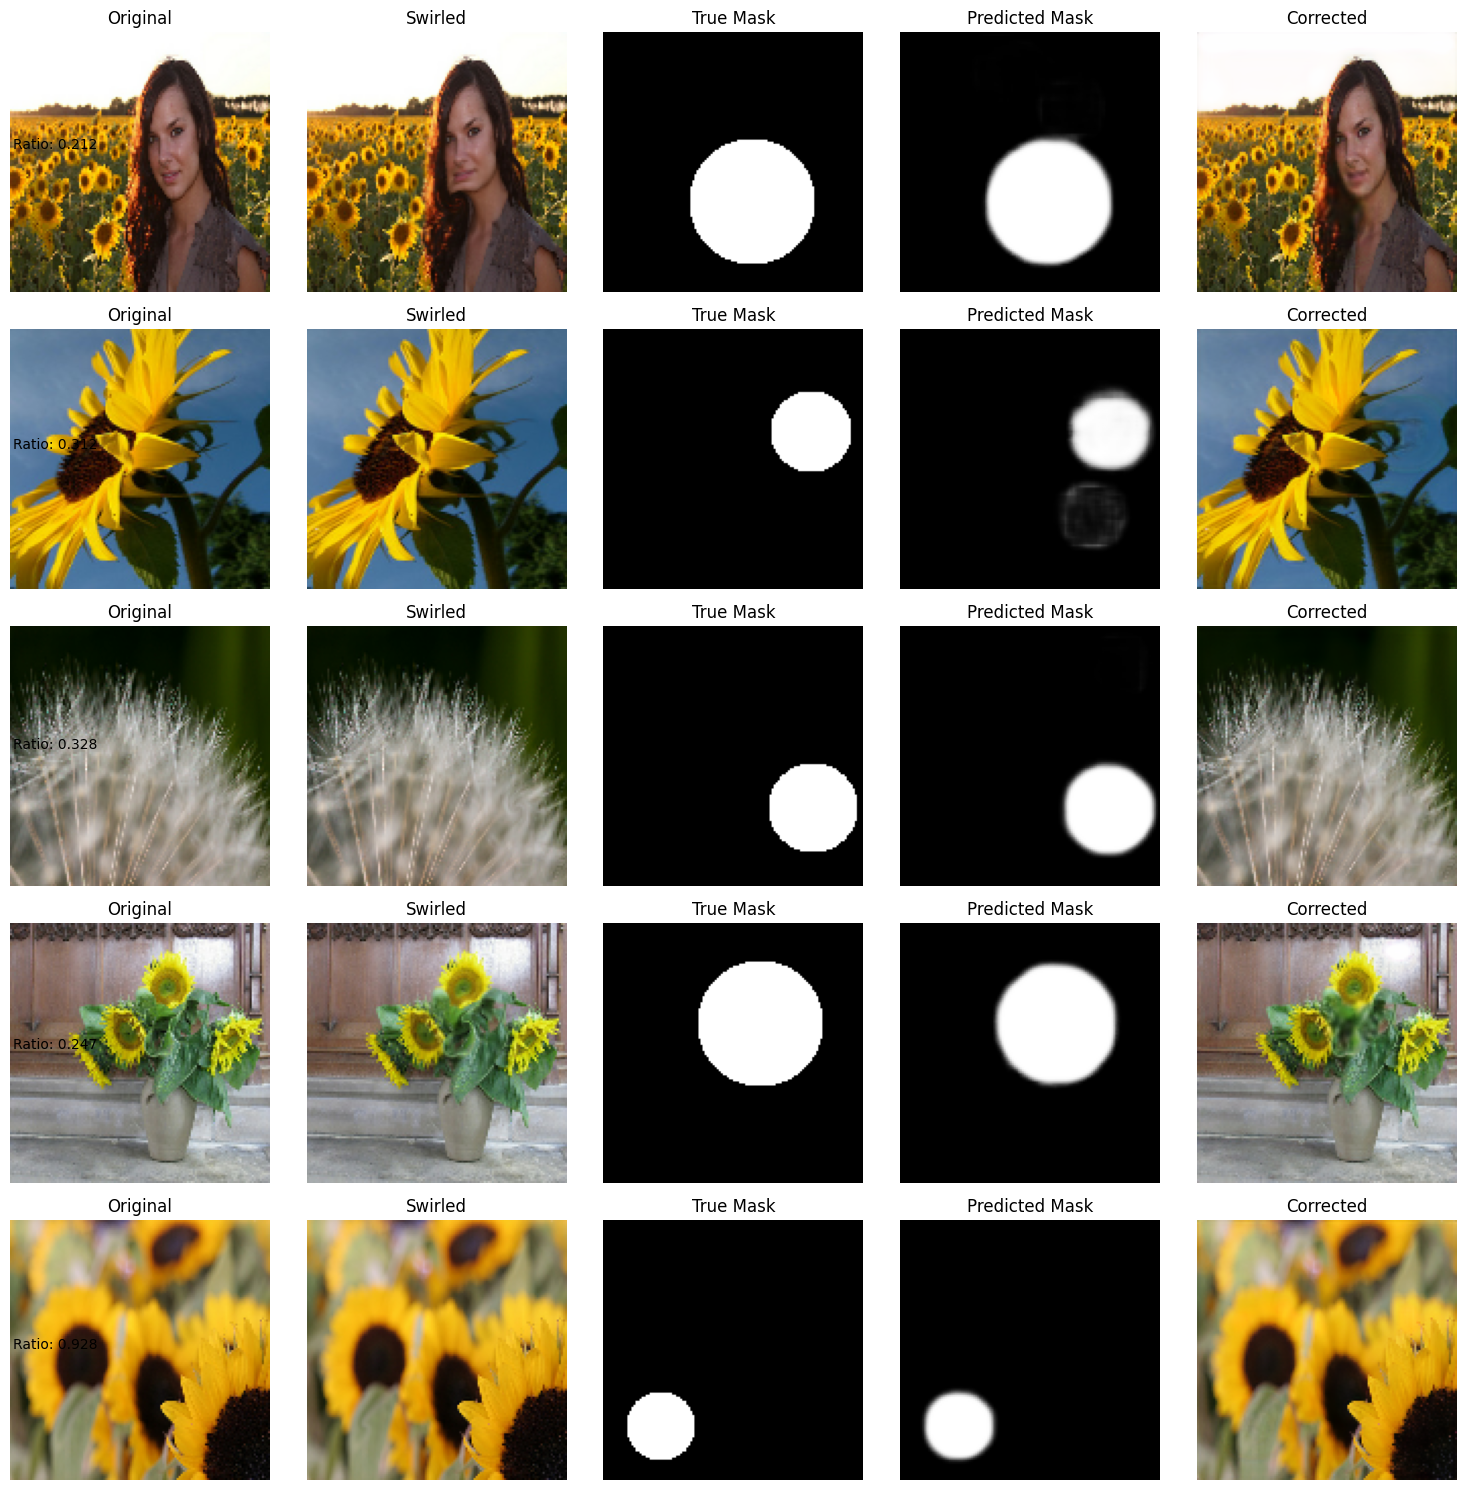

In [46]:

print("\n" + "="*50)
print("VISUALIZING RESULTS")
print("="*50)

def visualize_results(correction_model, mask_model, test_gen, num_samples=5):
    """Visualizza risultati del modello guidato da maschera"""

    # batch from test set
    x_defected, y_mask_gt, y_clean = test_gen[0]

    # random 'num_samples'
    indices = np.random.choice(len(x_defected), num_samples, replace=False)
    x_sel = x_defected[indices]
    y_sel = y_clean[indices]
    mask_gt_sel = y_mask_gt[indices]

    # predict mask and correct images
    m_pred = mask_model.predict(x_sel, verbose=0)                  # (B,128,128,1)
    m_pred3 = np.repeat(m_pred, 3, axis=-1).astype(np.float32)     # (B,128,128,3)

    pred_corrected = correction_model.predict(
        {"defected_img": x_sel, "pred_mask": m_pred3},
        verbose=0
    )

    # Plot
    fig, axes = plt.subplots(num_samples, 5, figsize=(15, 3*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        idx = indices[i]

        # Original
        axes[i, 0].imshow(y_sel[i])
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')

        # Swirled
        axes[i, 1].imshow(x_sel[i])
        axes[i, 1].set_title('Swirled')
        axes[i, 1].axis('off')

        # True Mask
        axes[i, 2].imshow(mask_gt_sel[i, :, :, 0], cmap='gray')
        axes[i, 2].set_title('True Mask')
        axes[i, 2].axis('off')

        # Predicted Mask
        axes[i, 3].imshow(m_pred[i, :, :, 0], cmap='gray')
        axes[i, 3].set_title('Predicted Mask')
        axes[i, 3].axis('off')

        # Corrected
        axes[i, 4].imshow(pred_corrected[i])
        axes[i, 4].set_title('Corrected')
        axes[i, 4].axis('off')

        #ration in the mask (mask GT)
        mask = mask_gt_sel[i]
        initial_error = np.sum((x_sel[i] - y_sel[i])**2 * mask) / (np.sum(mask) + 1e-8)
        correction_error = np.sum((pred_corrected[i] - y_sel[i])**2 * mask) / (np.sum(mask) + 1e-8)
        ratio = correction_error / (initial_error + 1e-8)

        # add ratio to the image
        fig.text(0.02, 1 - (i+0.5)/num_samples, f'Ratio: {ratio:.3f}',
                 fontsize=10, ha='left', va='center')

    plt.tight_layout()
    plt.show()

visualize_results(correction_model, mask_model, test_gen)
